# Analyzing Campaign Finance Data to Predict Election Results

**Tony Wu  
CMSC 320  
Fall 2022**

<img src="img/election_map.png">

## Introduction

We've all seen political advertisements in our day to day lives, whether they be on television, on the radio, or online. They can be difficult to avoid, especially during election season. These advertisements are often funded by campaign finance, and it's interesting to consider the correlation between campaign spending and the results of elections.

Do candidates who spend more money on advertising generally receive more votes? Do they have a better chance of winning? By analyzing campaign finance data and voting results, we can gain a better understanding of the role that money plays in politics and how much it influences a candidate's chances of winning an election.

After following this tutorial, you will be able to
1. Scrape data from websites
2. Clean and organize data from multiple sources
3. Perform exploratory analysis to identify trends
4. Graph and model relationships in data
5. Perform hypothesis testing to draw conclusions

Whether you are a political science student, a data science enthusiast, or simply curious about the role of money in politics, this tutorial will provide a useful introduction to the data science pipeline and to analyzing campaign finance. For this tutorial, I will specifically analyze the 2022 midterm elections as that just recently concluded.

### Hypothesis

I hypothesize that as a candidate spends more on a campaign, they will get more votes and have a better chance of winning. This makes sense because they can spend more on advertisements and influence more money. I also hypothesize that spending in close elections is higher because candidates have more of a chance to influence the election.

### Packages

In [1]:
from fuzzywuzzy import fuzz, process
from zipfile import ZipFile
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm

## Data Collection

The Federal Election Commission (FEC) stores all campaign finance data in the United States. If we go to the website and navigate to the [bulk data section](https://www.fec.gov/data/browse-data/?tab=bulk-data), we can fetch the data for all candidates in 2021-2022.

Fetching the 2022 midterm results is a bit more complicated. The Los Angeles Times contains a good list of all of the [election results](https://www.latimes.com/projects/2022-election-US-house-senate-governors-live-results/). However, scraping this does not work because the results are loaded dynamically. Instead, we look in the dev tools to find the network connections of the website.

<img src="img/network.png">

From this, we can see that the Los Angeles Times retrieves all of the election data from 2 JSON files: `latest-house.json` and `latest-senate.json`. We can now download all of the data into the `data` directory.

In [2]:
# URLs for the data
finance_url = "https://www.fec.gov/files/bulk-downloads/2022/weball22.zip"
house_url = "https://bigbuilder.s3.us-west-1.amazonaws.com/projects/elections-data/2022-11-08/latest-house.json"
senate_url = "https://bigbuilder.s3.us-west-1.amazonaws.com/projects/elections-data/2022-11-08/latest-senate.json"

# Download campaign finance data from the FEC
response = requests.get(finance_url)
with open("data/candidates.zip", "wb") as f:
    f.write(response.content)

# Unzip into data directory
with ZipFile("data/candidates.zip", "r") as f:
    f.extractall("data")

# Download house election results
response = requests.get(house_url)
with open("data/house.json", "wb") as f:
    f.write(response.content)

# Download senate election results
response = requests.get(senate_url)
with open("data/senate.json", "wb") as f:
    f.write(response.content)

## Data Processing

### Finance Data

We now load the campaign finance data into a Pandas DataFrame. There are a lot of columns, listed [here](https://www.fec.gov/campaign-finance-data/all-candidates-file-description/), but the ones we are interested in are candidate's name, party, total spent, state, and district.

The name is currrently one column, but we want both the first and last name because the other dataset includes them. We can easily split by the comma delimiter to separate the names.

In [3]:
# Read data into finance_df dataframe and keep important columns
finance_df = pd.read_csv("data/weball22.txt", sep="|", header=None)[[1, 4, 7, 18, 19]]
finance_df.columns = ["name", "party", "total_spent", "state", "district"]
finance_df

# Split the name column into first and last name
df = finance_df["name"].str.split(", ", n=1, expand=True)
df.columns = ["last_name", "first_name"]
finance_df = df.join(finance_df.iloc[:, 1:])
finance_df

,last_name,first_name,party,total_spent,state,district
0,CONSTANT,CHRISTOPHER,DEM,164037.51,AK,0.0
1,PELTOLA,MARY,DEM,6506330.37,AK,0.0
2,WOOL,ADAM L,DEM,16217.07,AK,0.0
3,REVAK,JOSHUA CARL,REP,121841.00,AK,0.0
4,PALIN,SARAH,REP,1908104.64,AK,0.0
...,...,...,...,...,...,...
4125,BEN DAVID,MERAV,DEM,14278.00,WY,0.0
4126,LUMMIS,CYNTHIA MARIE MRS.,REP,352180.98,WY,0.0
4127,MILLER,BRYAN,REP,0.00,WY,0.0
4128,BARRASSO,JOHN A,REP,1323311.92,WY,0.0


We can check for duplicates.

In [4]:
# Find candidates with duplicate entries
finance_df[finance_df.duplicated(subset=["last_name", "first_name"], keep="last")]

,last_name,first_name,party,total_spent,state,district
22,COLEMAN,JEFF,REP,0.00,AL,2.0
36,BROOKS,MO,REP,4732229.28,AL,5.0
68,COTTON,THOMAS,REP,3069187.01,AR,4.0
88,MARTIN,BRANDON RAY,REP,606.19,AZ,2.0
114,OLSON,JUSTIN,REP,0.00,AZ,5.0
...,...,...,...,...,...,...
3723,BIERY,DAVID,IND,150.75,KY,0.0
3738,KENNEDY,JOSEPH P III,DEM,349348.51,MA,0.0
3868,SIVALINGAM,TEJASINHA,REP,794.78,NH,0.0
3973,TAHER,IBRAHIM,REP,8153.12,OR,0.0


We see that there are 126 duplicate names. In order to fix this, we will drop any duplicates, keeping the entry that has spent more money. This is because a lot of the duplicates have $0 spent and it makes more sense to keep the entry which more accurately describes how much a candidate spent.

In [5]:
# Sort by total spent and keep the first entry for duplicates
finance_df = (
    finance_df[finance_df["total_spent"] > 0]
    .sort_values("total_spent", ascending=False)
    .drop_duplicates(subset=["first_name", "last_name"], keep="first")
)
finance_df

,last_name,first_name,party,total_spent,state,district
3376,MERCER JR,LEE,DEM,3.840000e+08,00,0.0
3616,WARNOCK,RAPHAEL,DEM,1.687255e+08,GA,0.0
3507,KELLY,MARK,DEM,9.165264e+07,AZ,0.0
3589,DEMINGS,VAL,DEM,8.106547e+07,FL,0.0
681,DEMINGS,VALDEZ 'VAL',DEM,8.106547e+07,FL,10.0
...,...,...,...,...,...,...
2925,HULINGS,JAY,DEM,3.460000e+00,TX,23.0
1566,BENTIVOLIO,KERRY,REP,2.800000e+00,MI,11.0
3770,OVERBY,PAULA MIRARE,DFL,2.060000e+00,MN,0.0
408,CORTES BARRAGAN,RODOLFO,GRE,1.680000e+00,CA,40.0


### Results Data

We now load the election result data from the JSON files into a Pandas DataFrame. The data has the following format.

<img src="img/json.png" height=500px>

Inside this dataset, there were 3 special elections that resulted in duplicate candidates. To deal with this, I only kept the first election because that showed the initial distribution of votes, including the third parties. The runoff elections only had 2 candidates and do not represent any third party candidates. The IDs for these pairs of special elections are `(2015, 3156)`, `(20645, 21405)`, and `(2933, 3153)`.

In addition, there were 3 duplicate elections that had no data. These had IDs `8516`, `15766`, and `21404`, which we will skip over. We can now process the JSON data.

In [6]:
# Retrieve JSON data
data = json.load(open("data/house.json")) + json.load(open("data/senate.json"))
candidates = []

# Iterate over each election
for row in data:
    # Remove duplicate candidate data and duplicate runoff elections
    if row["id"] in ["8516", "15766", "21404", "3156", "21405", "3153"]:
        continue

    # Iterate over each candidate in the election
    for i, candidate in enumerate(row["candidates"]):
        # Remove candidates with no votes and write-in candidates
        if candidate["votes"] == 0 or candidate["family_name"] == "Total Write-Ins":
            continue

        # For the runoff elections, the first candidate won each time
        if row["id"] in ["2015", "20645", "2933"] and i == 0:
            candidate["is_winner"] = True

        # District is 0 for senate
        if row["office_id"] == "S":
            district = 0
        else:
            district = row["seat_number"]

        # Change gop to REP to match with the campaign finance dataset
        if candidate["party"] == "gop":
            candidate["party"] = "REP"

        # Add candidate information
        candidates.append(
            {
                "last_name": candidate["family_name"].upper(),
                "first_name": candidate["given_name"].upper(),
                "state": row["state_postal"],
                "district": district,
                "party": candidate["party"].upper(),
                "is_winner": candidate["is_winner"],
                "is_incumbent": candidate["is_incumbent"],
                "votes": candidate["votes"],
            }
        )

# Create Pandas DataFrame
votes_df = pd.DataFrame(candidates)
votes_df

,last_name,first_name,state,district,party,is_winner,is_incumbent,votes
0,PELTOLA,MARY,AK,1,DEM,True,True,128329
1,PALIN,SARAH,AK,1,REP,False,False,67732
2,BEGICH,NICK,AK,1,REP,False,False,61431
3,BYE,CHRIS,AK,1,LIB,False,False,4560
4,CARL,JERRY,AL,1,REP,True,True,139854
...,...,...,...,...,...,...,...,...
1165,ERICSON,MS. CRIS,VT,0,IND,False,False,1102
1166,MURRAY,PATTY,WA,0,DEM,True,True,1741827
1167,SMILEY,TIFFANY,WA,0,REP,False,False,1299322
1168,JOHNSON,RON,WI,0,REP,True,True,1336928


## Combining Datasets

We can now combine our finance data with the results data. The main problem to overcome is the fact that a lot of the names do not match exactly. For example, the finance data has an entry for `JOHN COCHRAN`, whereas the results data has an entry for `JOHNNY COCHRAN`.


In [7]:
display(votes_df[votes_df["last_name"] == "COCHRAN"])
display(finance_df[finance_df["last_name"] == "COCHRAN"])

,last_name,first_name,state,district,party,is_winner,is_incumbent,votes
8,COCHRAN,JOHNNY,AL,4,LIB,False,False,4294


,last_name,first_name,party,total_spent,state,district
34,COCHRAN,JOHN,LIB,6298.7,AL,4.0


This is the same Libertarian candidate for Alabama Congressional District 4, but the names do not match. So, we can use fuzzy matching provided by the `fuzzywuzzy` Python library, which allows us to match inexact strings.

We first ensure that the candidates are from the same state. Then, we match candidates with very similar names: the first name from one dataset is a subset of the first name from the other dataset and the same for last names. We do this because many of the names have suffixs such as `DR`, `PHD`, and `MR`.

If this fails, we fuzzy match on candidates. We ensure that the state matches. Then, we check cases where the first name is a match or the second name is a match. We then fuzzy match the rest of the name with a threshold of 80% to ensure that the names are actually close together.

In [8]:
data = []

# Iterate over candidates from the election results data
for _, row in votes_df.iterrows():
    # Find very close name matches (subsets)
    df = finance_df[
        (
            (finance_df["state"] == row["state"])
            & (finance_df["last_name"].str.contains(row["last_name"]))
            & (finance_df["first_name"].str.contains(row["first_name"]))
        )
    ]

    # If this fails, try to find a close name match
    if len(df) == 0:
        # Limit to candidates in the same state and with matching first or last names
        state_df = finance_df[
            (finance_df["state"] == row["state"])
            & (
                (finance_df["first_name"] == row["first_name"])
                | (finance_df["last_name"] == row["last_name"])
            )
        ]

        # Search all of these candidates for a close name match
        if len(state_df) > 0:
            closest = process.extract(
                row["first_name"] + " " + row["last_name"],
                state_df["first_name"] + " " + state_df["last_name"],
                limit=1,
            )[0]

            # Isolate the entry for the candidate with the closest name match
            if closest[1] >= 80:
                df = finance_df[
                    finance_df["first_name"] + " " + finance_df["last_name"]
                    == closest[0]
                ]

    # Add data if there is a match
    if len(df) >= 1:
        # If there are multiple entries, choose the one with the most money spent
        total_spent = df.loc[df["total_spent"].idxmax()]["total_spent"]
        data.append(
            {
                "last_name": row["last_name"],
                "first_name": row["first_name"],
                "state": row["state"],
                "district": row["district"],
                "party": row["party"],
                "is_winner": row["is_winner"],
                "is_incumbent": row["is_incumbent"],
                "total_spent": total_spent,
                "votes": row["votes"],
            }
        )

data_df = pd.DataFrame(data)
data_df

,last_name,first_name,state,district,party,is_winner,is_incumbent,total_spent,votes
0,PELTOLA,MARY,AK,1,DEM,True,True,6506330.37,128329
1,PALIN,SARAH,AK,1,REP,False,False,1908104.64,67732
2,BEGICH,NICK,AK,1,REP,False,False,1552558.33,61431
3,BYE,CHRIS,AK,1,LIB,False,False,3940.25,4560
4,CARL,JERRY,AL,1,REP,True,True,931386.18,139854
...,...,...,...,...,...,...,...,...,...
908,COESTER,MARK,VT,0,IND,False,False,9394.38,1270
909,MURRAY,PATTY,WA,0,DEM,True,True,18778781.04,1741827
910,SMILEY,TIFFANY,WA,0,REP,False,False,20150770.46,1299322
911,JOHNSON,RON,WI,0,REP,True,True,33830890.07,1336928


The resulting dataset has `913` rows. We now have information on candidate's name, election's state and district, candidate's party, boolean flags for winner and incumbent, total money spent, and the number of votes for the candidate.

## Exploration

We can now being exploring and analyzing our data. We can take a look at the general statistics.

In [9]:
data_df.describe()

,total_spent,votes
count,9.130000e+02,9.130000e+02
mean,3.047781e+06,1.939655e+05
std,9.155355e+06,4.220941e+05
min,2.060000e+00,2.460000e+02
25%,1.311495e+05,7.976600e+04
50%,1.075978e+06,1.282610e+05
75%,2.721977e+06,1.655830e+05
max,1.687255e+08,6.559303e+06


From this, we notice that there is a very large range for both total spent and votes. The standard deviation is higher than the mean for both datasets, and the maximum is significantly higher than the 75th percentile. We can graph some violin plots of both variables to better visualize the distributions.

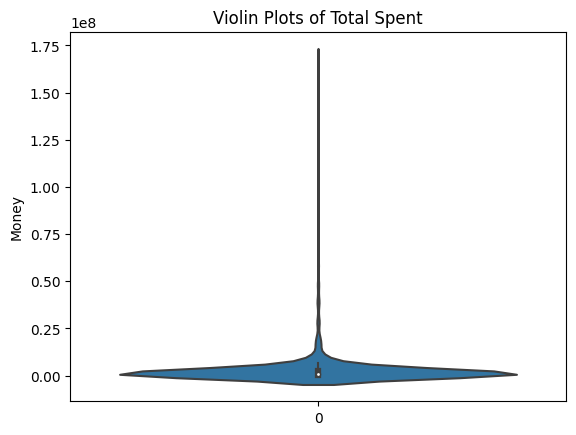

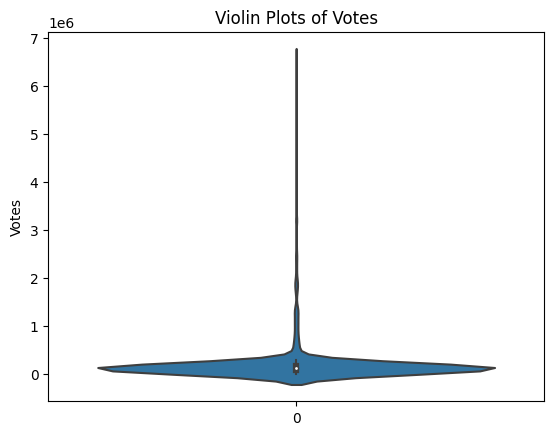

In [10]:
# Violin plot of total spent
sns.violinplot(data=data_df["total_spent"]).set(
    title="Violin Plots of Total Spent",
    ylabel="Money",
)
plt.show()

# Violin plot of votes
sns.violinplot(data=data_df["votes"]).set(
    title="Violin Plots of Votes",
    ylabel="Votes",
)
plt.show()

These distributions are both heavily skewed towards the lower end, which makes sense. There are a few campaigns that spend a lot, but most candidates do not spend a lot of money on their campaigns.

## Analysis

### Effect of Money on Votes

We are interested in the relationship between total money spent and number of votes. We can graph a scatter plot of total spent versus votes and plot a regression line.

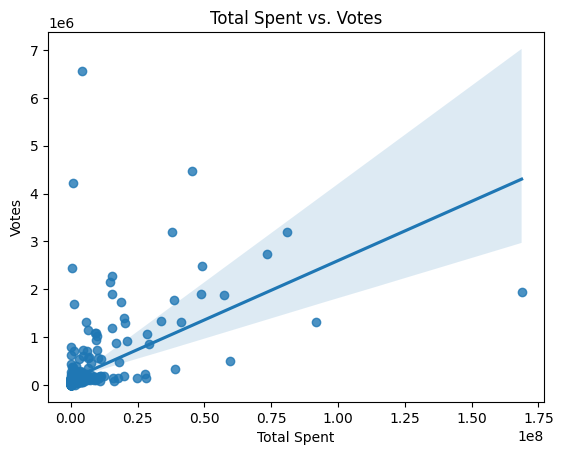

In [11]:
# Scatter plot and regression line
sns.regplot(data=data_df, x="total_spent", y="votes").set(
    title="Total Spent vs. Votes",
    xlabel="Total Spent",
    ylabel="Votes",
)
plt.show()

There seems to be a clear trend between total spent and number of votes. As a candidate spends more, they generally get more votes. However, the correlation is moderate. We can use the `statsmodel` package's ordinary least square regression (OLS) to find exact statistics.

In [12]:
# Linear regression statistics
y = data_df["votes"]
x = data_df["total_spent"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  votes   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     370.8
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.37e-69
Time:                        20:42:37   Log-Likelihood:                -12965.
No. Observations:                 913   AIC:                         2.593e+04
Df Residuals:                     911   BIC:                         2.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.184e+05   1.24e+04      9.533      

The P-value associated with the F-statistic is `1.37e-69`, which is almost 0. This means that there is a relationship between total spent and votes. The R^2 value of the linear regression is `0.289`, which means `28.9%` of the variation in votes can be explained by the amount spent. So, there is a clear correlation that is moderately strong.

### Normalizing Data

We want to see how close elections are as well. To do this, we will have to compare number of votes between candidates in the same state and district. Different districts have different populations, so the amount of votes will change. So, we will normalize the data by finding the percentage of votes gained for each candidate.

In [13]:
# Create a new column for percentage of votes won
data_df["vote_percent"] = data_df.apply(
    lambda row: row["votes"] / data_df[
        (data_df["state"] == row["state"]) & (data_df["district"] == row["district"])
    ]["votes"].sum(),
    axis=1,
)

# Remove elections with only 1 candidate
data_df = data_df[data_df["vote_percent"] != 1]
data_df

,last_name,first_name,state,district,party,is_winner,is_incumbent,total_spent,votes,vote_percent
0,PELTOLA,MARY,AK,1,DEM,True,True,6506330.37,128329,0.489708
1,PALIN,SARAH,AK,1,REP,False,False,1908104.64,67732,0.258468
2,BEGICH,NICK,AK,1,REP,False,False,1552558.33,61431,0.234423
3,BYE,CHRIS,AK,1,LIB,False,False,3940.25,4560,0.017401
5,ADERHOLT,ROBERT,AL,4,REP,True,True,973923.28,164371,0.841664
...,...,...,...,...,...,...,...,...,...,...
908,COESTER,MARK,VT,0,IND,False,False,9394.38,1270,0.004586
909,MURRAY,PATTY,WA,0,DEM,True,True,18778781.04,1741827,0.572753
910,SMILEY,TIFFANY,WA,0,REP,False,False,20150770.46,1299322,0.427247
911,JOHNSON,RON,WI,0,REP,True,True,33830890.07,1336928,0.504958


Now that the data is normalized, we can graph a scatter plot of the vote percent versus total spent.

<AxesSubplot:title={'center':'Vote Percent vs. Total Spent'}, xlabel='Vote Percent', ylabel='Total Spent'>

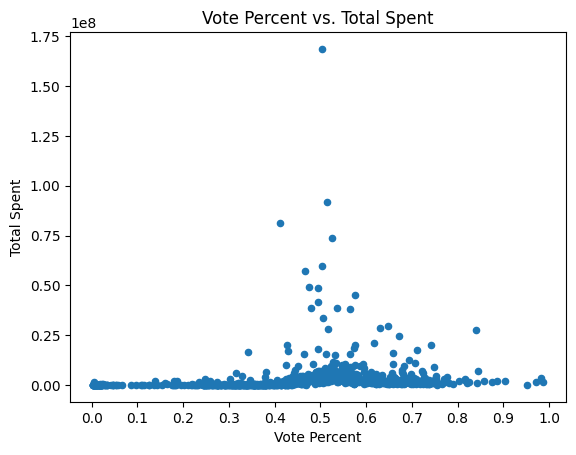

In [14]:
data_df.plot(
    kind="scatter",
    title="Vote Percent vs. Total Spent",
    xlabel="Vote Percent",
    ylabel="Total Spent",
    x="vote_percent",
    y="total_spent",
    xticks=np.arange(0.0, 1.1, 0.1)
)

From this plot, we can see a clear peak around 50% votes won, which means that candidates in close elections spend significantly more than candidates that won or lost easily. This makes sense because candidates that are unlikely to win are less likely to spend more money.

### Close Elections

We can analyze the relationship between money spent and vote percent in close elections. We limit the dataset to elections where the vote percent was between 35% and 65%. We can then graph a scatter plot and fit a linear regression.

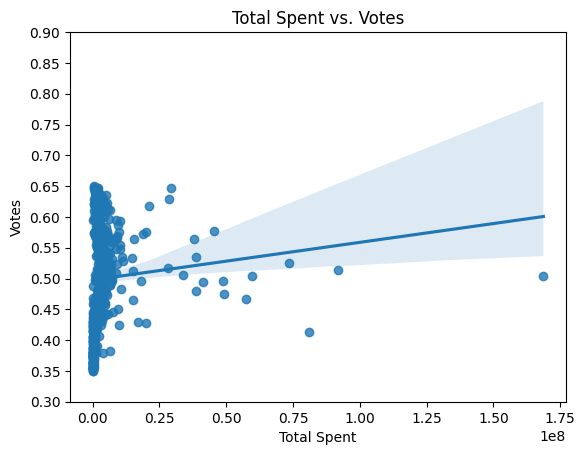

In [15]:
# Scatter plot and regression line
close_df = data_df[abs(data_df["vote_percent"] - 0.5) < 0.15]
sns.regplot(data=close_df, x="total_spent", y="vote_percent").set(
    title="Total Spent vs. Votes",
    xlabel="Total Spent",
    ylabel="Votes",
    yticks=np.arange(0.3, 0.9, 0.05)
)
plt.show()

This correlation is much weaker than before. It seems that close elections are harder to sway by spending more money. Spending more money only increases the change of winning an election by a small amount. We once again use `statsmodel` to see the statistics.

In [16]:
# Linear regression statistics
y = close_df["vote_percent"]
x = close_df["total_spent"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_percent   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.429
Date:                Fri, 16 Dec 2022   Prob (F-statistic):             0.0647
Time:                        20:42:38   Log-Likelihood:                 486.37
No. Observations:                 477   AIC:                            -968.7
Df Residuals:                     475   BIC:                            -960.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4977      0.004    116.227      

The P-value for the F-statistic is `0.0647`, which is evidence that there is still a correlation between money spent and winning chances. However, the `R^2` value is much lower this time at `0.007`. From the coefficients, the formula for the linear regression is `vote percent = 0.4977 + 6.105e-10 (money)`. This means that spending approximately `$16.4 million` more leads to an increase of `%1 chance` of winning the election.

## Conclusion

### Insights

We have analyzed our campaign finance data along with the election results data. From the graph of total spent versus number of votes gained, we can see that overall, there is definitely a correlation between campaign spending and gaining more votes. The linear regression showed that 28.9% of the variation in votes could be explained by the amount of money spent.

We also normalized the number of votes based on the state and the district, which allowed us to see that campaign spending in close elections is significantly higher. Upon closer analysis of these elections, we saw that election spending had a much smaller impact in close elections. The linear regression showed that only 0.7% of the variation in vote percentage could be explained by the amount spent.

One way to explain these results is that in close elections, both sides are campaigning heavily and spending large amounts of money. So, the amount of money that they spend does not matter as much.

### Final Thoughts

Campaign finance data can provide valuable insights into the factors that may influence election results. It allows us to gain a better understanding of the strategies and tactics used by candidates.

However, it's important to recognize that campaign finance is just one aspect of elections. Factors, such as voter demographics, public opinion, and media coverage also play a significant role in determining the outcome of elections.

From this tutorial, you have seen multiple ways to approach and analyze data with a critical eye to explore how campaign finance may influence election results. By doing so, we have gained knowledge about our data that can inform our understanding of the political landscape.